In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import math

from cmdstanpy import CmdStanModel

Below we repeat the analysis that was done in the original simulation.

In [2]:
chicks = pd.read_table("chickens.dat", sep="\\s+")
chicks["exposed_est"] -= 1
chicks["sham_est"] -= 1
chicks.head()

,freq,sham_n,sham_est,sham_se,exposed_n,exposed_est,exposed_se
0,1,32,-0.005,0.041,32,0.036,0.041
1,15,32,0.013,0.042,36,0.173,0.034
2,30,32,0.033,0.032,32,0.107,0.035
3,45,32,-0.010,0.032,32,0.181,0.052
4,60,32,-0.002,0.040,32,0.136,0.044


In [3]:
chick_model = CmdStanModel(stan_file="dynamic_hier.stan")
chick_data = {
    "num_expts": len(chicks),
    "avg_treated_response": chicks["exposed_est"],
    "avg_control_response": chicks["sham_est"],
    "treated_se": chicks["exposed_se"],
    "control_se": chicks["sham_se"],
    "expt_id": list(range(1, len(chicks) + 1)),
}
chick_fit = chick_model.sample(data=chick_data, adapt_delta=0.9)

11:50:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:50:28 - cmdstanpy - INFO - CmdStan done processing.


The function below simulates a dataset for `num_experiments` experiments, all assumed to have the same proportion `prop_treatment` allocated to the treatment group. Here one complication is that the original simulation assumes all experiments have the same number of subjects in the control and treatment groups.

The original assumptions are:

$$
\begin{align*}
    y_{j1} \mid \theta_j, b_j &\sim N(\theta_j + b_j, s_{j1}) \\
    y_{j0} \mid b_j &\sim N(b_j, s_{j0}) \\
    \theta_j &\sim N(\mu_\theta, \sigma_\theta) \\
    b_j &\sim N(\mu_b, \sigma_b)
\end{align*}
$$

These assumptions mostly still work here since $s_{j1}$ and $s_{j0}$ need not be the same for all experiments $j$. However, in the original simulation, it was assumed that $s_{j1} = s_{j0} = 0.04$ for all $j$. This is reasonable if the treatment and control groups have the same size and if we expect the treatment/sham effects to have similar spread, which was empirically shown for the chicken dataset. 

However, if the groups have unequal numbers of subjects, then we expect the group with fewer subjects to have higher variance. We let $Y_{j0}^{(i)}$ and $Y_{j1}^{(k)}$ be the outcomes for the $i$-th and $k$-th individuals in the control and treatment groups respectively for experiment $j$. Let the $j$-th experiment have $N_{j0}$ and $N_{j1}$ subjects in control and treatment groups respectively. If the number of subjects in each group is at least 30, then assuming the individual outcomes are iid, the CLT gives

$$ y_{j1} = \frac{1}{N_{j1}} \sum_{k=1}^{N_{j1}} Y_{j1}^{(k)} \rightarrow N(\mu_{j1}, \sigma_{j1}) $$

where $\sigma_{j1} = \sqrt{\frac{\text{var}(Y_{j1})}{N_{j1}}}$ and similarly for $y_{j0}$. We identify $\mu_{j1}$ with $\theta_j + b_j$ and $\sigma_{j1}$ with $s_{j1}$. Since $s_{j1} = 0.04$ in the original simulation, we use $\text{var}(Y_{j1}) = 32 \times (0.04)^2$ for all experiments $j$; likewise for $\text{var}(Y_{j0})$.

*Thought: What if the sample sizes are too small for the CLT? Maybe bootstrap or make distributional assumptions on $Y_{j1}^{(k)}$?*

In [4]:
def fake_expts_with_prop(
    num_subjects_per_expt,
    prop_treatment,
    mu_b,
    mu_theta,
    sigma_b,
    sigma_theta,
    sigma_treatment,
    sigma_control,
):
    """
    Generate synthetic data with a specified proportion of treated subjects.

    Args:
    num_subjects_per_expt: A list of integers, the number of subjects in each
        experiment.
    prop_treatment: A float, the proportion of subjects that are treated.
    mu_b: A float, the true (mean) of the control group response.
    mu_theta: A float, the true (mean) treatment effect.
    sigma_b: A float, the standard deviation of b_j.
    sigma_theta: A float, the standard deviation of theta_j.
    sigma_treatment: A float, the standard deviation of the treated group
        response.
    sigma_control: A float, the standard deviation of the control group
        response.
    """
    assert len(num_subjects_per_expt) == len(prop_treatment)
    assert sigma_theta >= 0 and sigma_b >= 0
    assert sigma_treatment >= 0 and sigma_control >= 0

    num_expts = len(num_subjects_per_expt)
    num_treated = np.floor(prop_treatment * num_subjects_per_expt).astype(int)
    num_control = num_subjects_per_expt - num_treated

    sigma_y1 = sigma_treatment / np.sqrt(num_treated)
    sigma_y0 = sigma_control / np.sqrt(num_control)

    theta = np.random.normal(mu_theta, sigma_theta, num_expts)
    b = np.random.normal(mu_b, sigma_b, num_expts)

    return {
        "true_params": {
            "mu_b": mu_b,
            "mu_theta": mu_theta,
            "sigma_b": sigma_b,
            "sigma_theta": sigma_theta,
            "sigma_treatment": sigma_treatment,
            "sigma_control": sigma_control,
        },
        "num_expts": len(num_subjects_per_expt),
        "avg_treated_response": np.random.normal(theta + b, sigma_y1),
        "avg_control_response": np.random.normal(b, sigma_y0),
        "treated_se": sigma_y1,
        "control_se": sigma_y0,
        "expt_id": list(range(1, num_expts + 1)),
    }

In [ ]:
def repeat_fake_expts(
    num_sims,
    num_subjects_per_expt,
    prop_treatment,
    mu_b,
    mu_theta,
    sigma_b,
    sigma_theta,
    sigma_treatment,
    sigma_control,
):
    """
    Repeat the generation of synthetic data multiple times.
    """
    pass

In [ ]:
def extract_statistics(model, data, alpha=0.05):
    fit = model.sample(data=data, iter_sampling=1000)

    # Get estimated theta_j and b_j from the posterior for each experiment j
    theta_j_hat = np.mean(fit.stan_variable("theta"), axis=0)
    b_j_hat = np.mean(fit.stan_variable("b"), axis=0)

    summary = {
        # estimate 1: theta_j = y_1
        "exposed_only": {
            "estimate": data["avg_treated_response"],
            "se": data["treated_se"],
        },
        # estimate 2: theta_j = y_1 - y_0
        "difference": {
            "estimate": data["avg_treated_response"] - data["avg_control_response"],
            "se": np.sqrt(data["treated_se"] ** 2 + data["control_se"] ** 2),
        },
        # estimate 3: theta_j averaged from posterior
        "posterior": {
            "estimate": theta_j_hat,
            "se": np.std(fit.stan_variable("theta"), axis=0),
        },
    }

    z_value = stats.norm.ppf(1 - alpha / 2)

    summary_dfs = {}
    for method in summary:
        estimate = summary[method]["estimate"]
        se = summary[method]["se"]

        if method == "posterior":
            thetas = fit.stan_variable("theta")
            conf_lower = np.quantile(thetas, alpha / 2, axis=0)
            conf_upper = np.quantile(thetas, 1 - alpha / 2, axis=0)
        else:
            conf_lower = estimate - z_value * se
            conf_upper = estimate + z_value * se

        # an observation is significant if 0 is not in the interval
        significant = ~((conf_lower < 0) & (0 < conf_upper))
        correct_sign = np.sign(data["true_params"]["mu_theta"]) == np.sign(estimate)
        error = data["true_params"]["mu_theta"] - estimate

        summary[method]["conf_lower"] = conf_lower
        summary[method]["conf_upper"] = conf_upper
        summary[method]["is_signif"] = significant
        summary[method]["correct_sign"] = correct_sign
        summary[method]["error"] = error

        summary_dfs[method] = pd.DataFrame(summary[method])

    return summary_dfs

In [95]:
chicks_avg_subjects = math.floor(np.mean(chicks["exposed_n"] + chicks["sham_n"]))
chick_mu_b = chick_fit.stan_variable("b").mean()
chick_mu_theta = chick_fit.stan_variable("theta").mean()
chick_se = (32 ** 0.5) * 0.04

balanced_sim = fake_expts_with_prop(
    num_subjects_per_expt=np.repeat(chicks_avg_subjects, len(chicks)),
    prop_treatment=np.repeat(0.5, len(chicks)),
    mu_b=0,
    mu_theta=chick_mu_theta,
    sigma_b=np.std(np.mean(chick_fit.stan_variable("b"), axis=0)),
    sigma_theta=np.std(np.mean(chick_fit.stan_variable("theta"), axis=0)),
    sigma_treatment=chick_se,
    sigma_control=chick_se,
)

In [96]:
balanced_summary = extract_statistics(chick_model, balanced_sim)

12:52:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:52:00 - cmdstanpy - INFO - CmdStan done processing.


12:46:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:46:18 - cmdstanpy - INFO - CmdStan done processing.
12:46:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'dynamic_hier.stan', line 28, column 4 to column 57)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'dynamic_hier.stan', line 28, column 4 to column 57)
Consider re-running with show_console=True if the above output is unclear!



(4000, 38)
-0.014463429999999998
4000
-0.014463429999999998


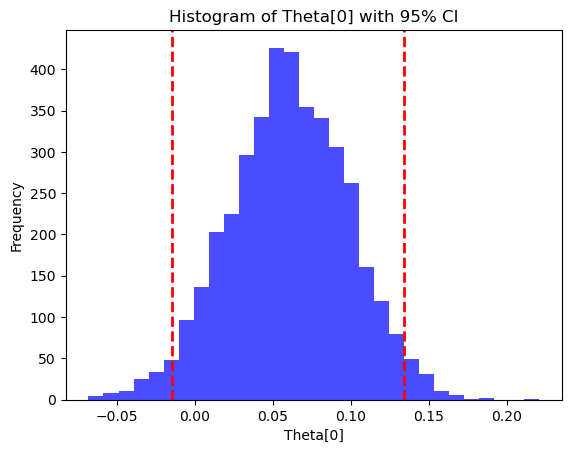

In [88]:
thetas = chick_model.sample(data=balanced_sim).stan_variable("theta")
print(thetas.shape)
lowers = np.percentile(thetas, 2.5, axis=0)
print(lowers[0])
print(len(thetas[:, 0]))
lower = np.percentile(thetas[:, 0], 2.5)
print(lower)
upper = np.percentile(thetas[:, 0], 97.5)
plt.hist(thetas[:, 0], bins=30, alpha=0.7, color='blue')
plt.axvline(lower, color='red', linestyle='dashed', linewidth=2)
plt.axvline(upper, color='red', linestyle='dashed', linewidth=2)
plt.xlabel('Theta[0]')
plt.ylabel('Frequency')
plt.title('Histogram of Theta[0] with 95% CI')
plt.show()

In [98]:
exposed_only_df = balanced_summary["exposed_only"]
difference_df = balanced_summary["difference"]
posterior_df = balanced_summary["posterior"]

In [ ]:
for method, df in balanced_summary.items():
    print(f"\n-------------{method}----------------:")
    print(f"  Proportion significant: {df["is_signif"].mean()}")
    print(f"  MSE: {np.mean(df["error"] ** 2)}")
    type_s_rate = len(df[df["is_signif"] & (~df["correct_sign"])]) / len(df[df["is_signif"]]) if len(df[df["is_signif"]]) > 0 else 0
    print(type_s_rate)
    print()


-------------exposed_only----------------:
  Proportion significant: 0.5263157894736842
  MSE: 0.005869013225547973
0


-------------difference----------------:
  Proportion significant: 0.42105263157894735
  MSE: 0.0080076591040212
0


-------------posterior----------------:
  Proportion significant: 0.631578947368421
  MSE: 0.002806990532678359
0



In [156]:
first_half = len(chicks) // 2
second_half = len(chicks) - first_half

num_subjects = np.concatenate([np.repeat(chicks_avg_subjects, first_half), 
    np.repeat(chicks_avg_subjects, second_half)])
imbalanced_prop = np.concatenate([np.repeat(0.95, first_half), np.repeat(0.7, second_half)])

print(len(imbalanced_prop))
print(len(num_subjects))

imbalanced_sim = fake_expts_with_prop(
    num_subjects_per_expt=num_subjects,
    prop_treatment=imbalanced_prop,
    mu_b=0,
    mu_theta=chick_mu_theta,
    sigma_b=np.std(np.mean(chick_fit.stan_variable("b"), axis=0)),
    sigma_theta=np.std(np.mean(chick_fit.stan_variable("theta"), axis=0)),
    sigma_treatment=chick_se,
    sigma_control=chick_se,
)

38
38


In [157]:
imbalanced_summary = extract_statistics(chick_model, imbalanced_sim)

00:46:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

00:46:24 - cmdstanpy - INFO - CmdStan done processing.


In [162]:
for method in imbalanced_summary:
    print(f"{method}:")
    print(f"  Proportion significant: {imbalanced_summary[method]['proportion_significant']}")
    print(f"  Type S rate: {imbalanced_summary[method]['type_s_rate']}")
    print(f"  MSE: {imbalanced_summary[method]['mse']}")
    print()

exposed_only:
  Proportion significant: 0.7631578947368421
  Type S rate: 0.0
  MSE: 0.003682709970192089

difference:
  Proportion significant: 0.34210526315789475
  Type S rate: 0.07692307692307691
  MSE: 0.012096909439819893

posterior:
  Proportion significant: 0.7631578947368421
  Type S rate: 0.0
  MSE: 0.0016399451990699618

